# OLA-2 Heart Disease Project

#

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the dataset.
df = pd.read_csv("../data/raw/heart_2020_cleaned.csv")

#

## Data Transformation

### Binary/Categorical Variables

In [3]:
# Encoding all features which include No/Yes to 0/1.
"""
    HeartDisease, Smoking, AlcoholDrinking, Stroke, DiffWalking,
    Diabetic, PhysicalActivity, Asthma, KidneyDisease, SkinCancer.
    (10)
"""
df = df.replace({"No": 0, "Yes": 1})

# Encoding "Sex" with 0/1.
df["Sex"] = df["Sex"].replace({"Female": 0, "Male": 1})
df["Sex"].value_counts()

# Encoding "Diabetic" with 0/1, but first we replace everything with No / Yes.
df["Diabetic"] = df["Diabetic"].replace(
    {
        "No, borderline diabetes": "No",
        "Yes (during pregnancy)": "Yes",
    }
)
df["Diabetic"] = df["Diabetic"].replace({"No": 0, "Yes": 1})
df["Diabetic"].value_counts()

Diabetic
0    276434
1     43361
Name: count, dtype: int64

### Ordinal Variables

In [4]:
# Categorizing and Encoding "AgeCategory" into 13 groups.
age_ranges = df["AgeCategory"].unique()
age_codes, _ = pd.factorize(age_ranges, sort=True)
age_range_to_code = dict(zip(age_ranges, age_codes))
df["AgeCategory"] = df["AgeCategory"].replace(age_range_to_code)
df["AgeCategory"].value_counts().sort_index()

# Categorizing and Encoding "BMI" into 4 different groups.
bmi_categories = ['Underweight (< 18.5)', 'Normal weight (18.5 - 25.0)', 'Overweight (25.0 - 30.0)', 'Obese (30 <)']
bmi_bins = [-np.inf, 18.5, 25.0, 30.0, np.inf]
df['BMI'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_categories)

dict_BMI = {category: code for code, category in enumerate(bmi_categories)}
df['BMI'] = df['BMI'].map(dict_BMI)
df["BMI"].value_counts()

# Categorizing and Encoding "GenHealth" into 5 different groups.
df["GenHealth"] = df["GenHealth"].replace(
    {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}
)
df["GenHealth"].value_counts()

GenHealth
3    113858
2     93129
4     66842
1     34677
0     11289
Name: count, dtype: int64

### Nominal Variables

In [5]:
# One-hot Encoding "Race" into 6 groups.
"""White, Hispanic, Black, Other, Asian, American Indian/Alskan Native."""
df = pd.get_dummies(df, columns=["Race"])
df.head()
# race_columns = [col for col in df.columns if col.startswith("Race_")]
# race_value_counts = df[race_columns].sum().sort_values(ascending=False)
# race_value_counts

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,0,1,0,0,3.0,30.0,0,0,7,...,5.0,1,0,1,False,False,False,False,False,True
1,0,1,0,0,1,0.0,0.0,0,0,12,...,7.0,0,0,0,False,False,False,False,False,True
2,0,2,1,0,0,20.0,30.0,0,1,9,...,8.0,1,0,0,False,False,False,False,False,True
3,0,1,0,0,0,0.0,0.0,0,0,11,...,6.0,0,0,1,False,False,False,False,False,True
4,0,1,0,0,0,28.0,0.0,1,0,4,...,8.0,0,0,0,False,False,False,False,False,True


#

## Data Preparation

In [6]:
# Define features and target.
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Splitting the dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Feature Scaling
* Removes Bias: Different features can have different scales 
    (e.g., age might range from 0 to 100, while income might range from thousands to millions). 
* Without standardization, features with larger scales can dominate the model's decision-making process.
    Improves Performance: Many machine learning algorithms, including SVM, 
    perform better when features are on a relatively similar scale.
* Assists in Comparison: Standardization makes the features more comparable and removes the units, 
    so you're not comparing apples and oranges.

In [7]:
# Standardizing the features (data preprocessing/feature scaling).

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Convert the scaled training features back to a DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

# Convert the scaled test features back to a DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

#

#

## Handling Imbalancing - Resampling Techniques

### Stratified Sampling

In [9]:
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train_stratified, X_test_stratified = X.iloc[train_index], X.iloc[test_index]
    y_train_stratified, y_test_stratified = y.iloc[train_index], y.iloc[test_index]

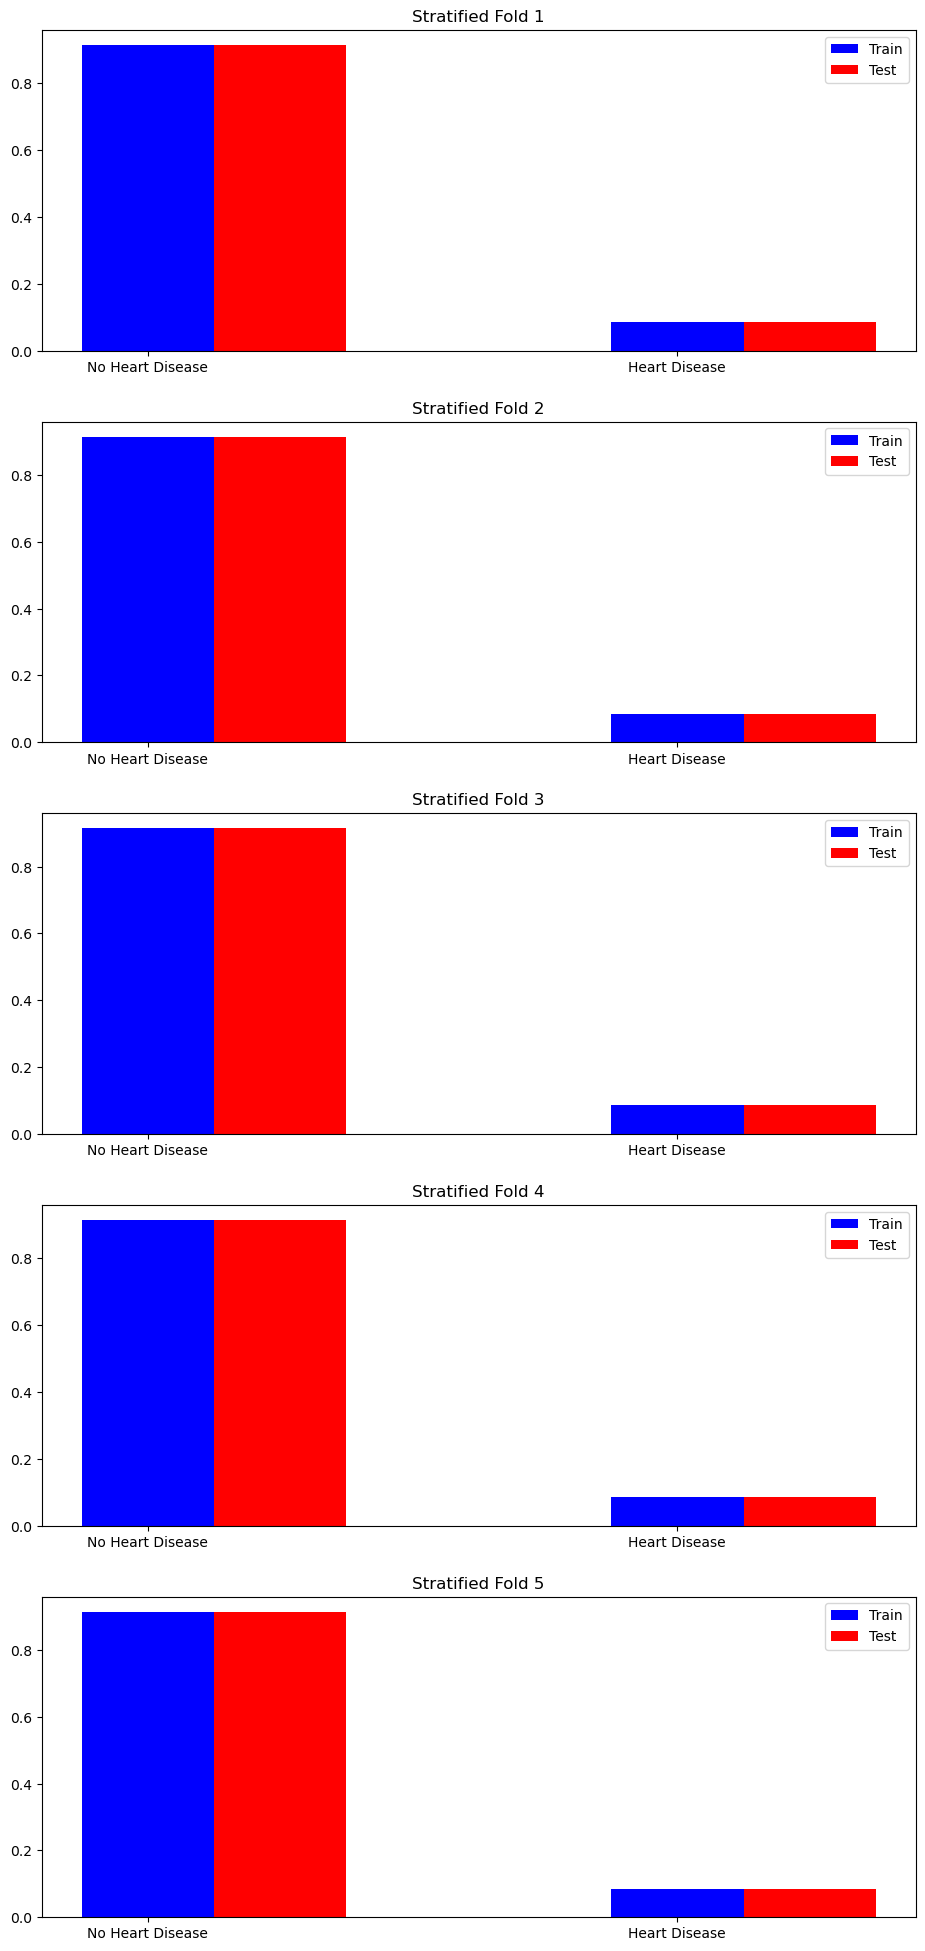

In [10]:
# Plotting the class distribution in each fold
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=3.0)

# Looping through each fold
for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Counting the frequency of each class in both train and test sets
    train_counts = y_train.value_counts(normalize=True)
    test_counts = y_test.value_counts(normalize=True)

    # Creating bar plots for each fold
    axes[i].bar(train_counts.index + 0.00, train_counts.values, color='blue', width=0.25, label='Train')
    axes[i].bar(test_counts.index + 0.25, test_counts.values, color='red', width=0.25, label='Test')
    axes[i].set_title(f'Stratified Fold {i+1}')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No Heart Disease', 'Heart Disease'])
    axes[i].legend()

plt.show()

#

### Random Oversampling

In [11]:
from imblearn.over_sampling import RandomOverSampler

Text(0, 0.5, 'Frequency')

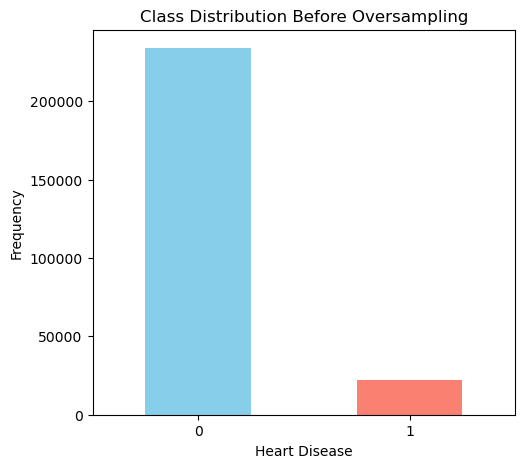

In [12]:
# Plotting the class distribution BEFORE oversampling:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=0)
plt.xlabel("Heart Disease")
plt.ylabel("Frequency")

In [13]:
# Random Oversampling
rd_oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = rd_oversampling = (
    rd_oversampler.fit_resample(X_train_scaled, y_train)
)

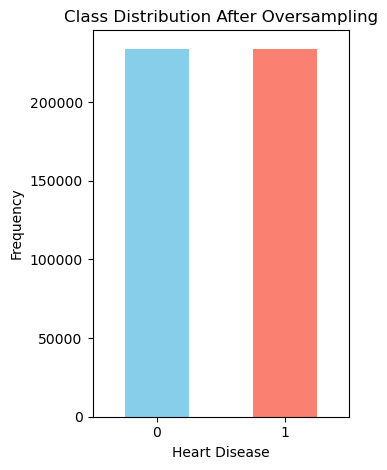

In [14]:
# Plotting the class distribution AFTER oversampling:
plt.subplot(1, 2, 2)
pd.Series(y_train_oversampled).value_counts().plot(
    kind="bar", color=["skyblue", "salmon"]
)
plt.title("Class Distribution After Oversampling")
plt.xticks(rotation=0)
plt.xlabel("Heart Disease")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [15]:
# Converting the oversampled training data back to a DataFrame:
X_train_oversampled_df = pd.DataFrame(X_train_oversampled, columns=X_train.columns)

# Convert the scaled test features back to a DataFrame
X_test_scaled_df = pd.DataFrame(
    X_test_scaled, index=X_test.index, columns=X_test.columns
)

#

### SMOTE Oversampling

> SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address the class imbalance problem in machine learning.
It generates synthetic samples of the minority class by interpolating between existing minority class samples.
This helps to balance the class distribution and improve the performance of machine learning models.
In this code, SMOTE is used to oversample the minority class in the training data (X_train, y_train).
The SMOTE algorithm is applied to create synthetic samples, increasing the number of minority class instances.
This helps to mitigate the impact of class imbalance and improve the accuracy of the logistic regression model.

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'split'

#

## Modeling

### Logistic Regression 

`(Without resampling)`

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create an instance of Logistic Regression
model = LogisticRegression()

In [ ]:
model.fit(X_train, y_train)

c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58484
           1       0.53      0.10      0.17      5475

    accuracy                           0.92     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.92      0.89     63959



In [ ]:
# Calculate the predicted probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

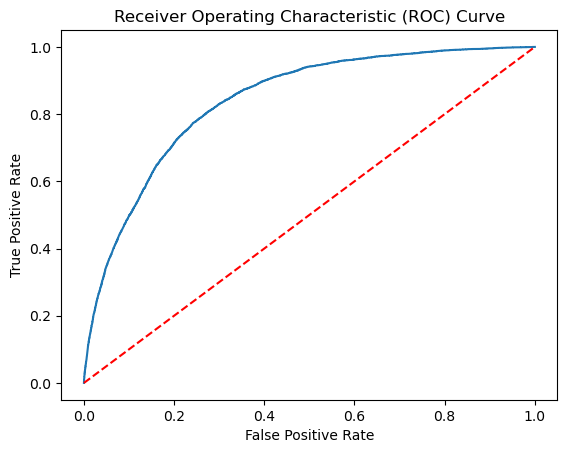

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(
    [0, 1], [0, 1], linestyle="--", color="r"
)  # Add the dotted line for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()


#### 1. Stratified Sampling

In [ ]:
model.fit(X_train_stratified, y_train_stratified)

# Evaluate the model
y_pred_stratified = model.predict(X_test_stratified)

print(classification_report(y_test_stratified, y_pred_stratified))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58484
           1       0.53      0.10      0.17      5475

    accuracy                           0.92     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.92      0.89     63959



c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2. Random Oversampling

In [ ]:
model.fit(X_train_oversampled, y_train_oversampled)

# Evaluate the model
y_pred_oversampled = model.predict(X_test)

print(classification_report(y_test, y_pred_oversampled))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     58484
           1       0.09      1.00      0.16      5475

    accuracy                           0.09     63959
   macro avg       0.04      0.50      0.08     63959
weighted avg       0.01      0.09      0.01     63959



c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\markl\anaconda3\envs\exam_ai_ml_workspace\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMe

#### 3. SMOTE Oversampling

In [ ]:
model.fit(X_train_stratified, y_train_stratified)

# Evaluate the model
y_pred_stratified = model.predict(X_test_stratified)

print(classification_report(y_test_stratified, y_pred_stratified))

#

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# Sampling since SMV takes a long time to evaluate when the dataset is large:
# 10% Used to test this model.
df = df.sample(frac=0.1, random_state=42)

X_train = df.drop("HeartDisease", axis=1)
y_train = df["HeartDisease"]

svm_model = SVC(random_state=42, class_weight="balanced")   # set to balanced
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
classification_report_output = classification_report(y_test, y_pred)
print(classification_report_output)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     58484
           1       0.21      0.80      0.33      5475

    accuracy                           0.72     63959
   macro avg       0.59      0.76      0.58     63959
weighted avg       0.91      0.72      0.78     63959



#### 1. Stratified Sampling

In [ ]:
svm_model = SVC(random_state=42, class_weight="balanced")   # set to balanced
svm_model.fit(X_train_stratified, y_train_stratified)

In [ ]:
y_pred_stratified = svm_model.predict(X_test_stratified)

classification_report_output = classification_report(y_test_stratified, y_pred_stratified)

#### 2. Random Oversampling

In [ ]:
svm_model = SVC(random_state=42, class_weight="balanced")   # set to balanced
svm_model.fit(X_train_oversampled, y_train_oversampled)

In [ ]:
y_pred_oversampled = svm_model.predict(X_test_stratified)

classification_report_output = classification_report(y_test_oversampled, y_pred_oversampled)

#

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

X_train = df.drop("HeartDisease", axis=1)
y_train = df["HeartDisease"]

# Initialize and train the random forest classifier with class_weight='balanced'
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

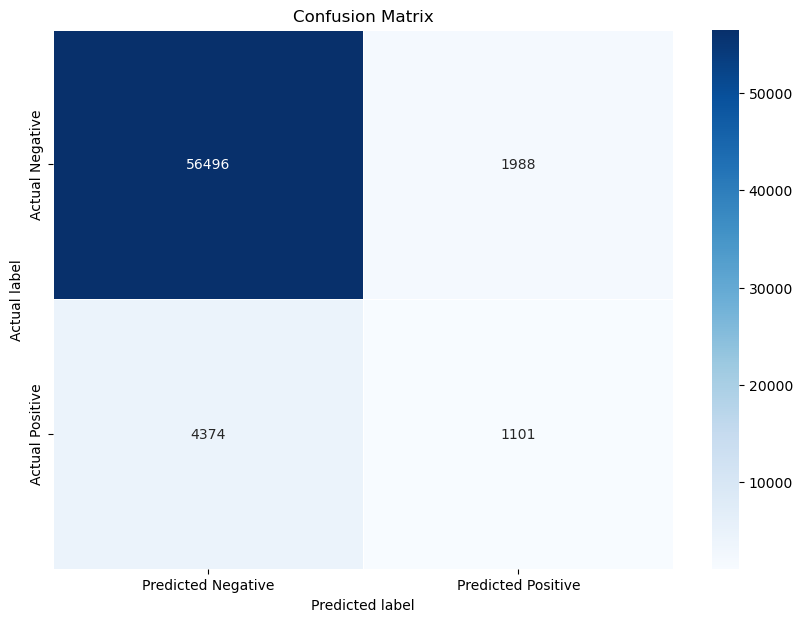

In [ ]:
# Confusion Matrix and Plotting
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     58484
           1       0.36      0.20      0.26      5475

    accuracy                           0.90     63959
   macro avg       0.64      0.58      0.60     63959
weighted avg       0.88      0.90      0.89     63959



#

## Modelling with Resampling

2. Random Oversampling

In [ ]:
model = LogisticRegression()

model.fit(X_train_stratified, y_train_stratified)

In [ ]:
model.fit(X_train_stratified, y_train_stratified)

# Evaluate the model 
y_pred_stratified = model.predict(X_test_stratified)

print(classification_report(y_test_stratified, y_pred_stratified))

In [ ]:
# Calculate the predicted probabilities
y_scores = model.predict_proba(X_test_stratified)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_stratified, y_scores)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(
    [0, 1], [0, 1], linestyle="--", color="r"
)  # Add the dotted line for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stratified)")
plt.show()